# IMPORTS, FUNCTIONS AND OTHER STATIC STUFF

In [1]:
from lime import our_lime
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from skimage.segmentation import mark_boundaries
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

### STATIC PATHS ###
ROOT_DIR = Path.cwd()
CAT_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'cat'
DOG_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'dog'
CATVSDOG_CLASSIFIER_WEIGHT_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'catvdog.pth'
ROOT_DIR = Path.cwd()

classes = ["Cat", "Dog"]

### COMPUTE DEVICE (CPU/GPU) ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

### FUNCTIONS ###
def get_image(path):
    #randomly pick a dog or cat image from image folder
    img_files = list(path.glob('*.jpg*'))
    img_file = random.choice(img_files)
    img_path_file = path / img_file
    with open(os.path.abspath(img_path_file), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
    
#check if paths are valid
if not Path(CAT_IMG_PATH):
    print(f"Warning: The cat image directory was not found:\n{CAT_IMG_PATH}")
if not Path(DOG_IMG_PATH):
    print(f"Warning: The dog image directory was not found:\n{DOG_IMG_PATH}")
if not Path(CATVSDOG_CLASSIFIER_WEIGHT_PATH):
    print(f"Warning: The blackbox classifier weights were not found:\n{BLACKBOX_CLASSIFIER_WEIGHT_PATH}")

Device: cuda


# Demo: ImageObject Class

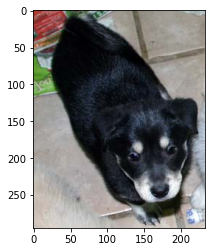

In [2]:
#pick random image
#random_image = get_image(CAT_IMG_PATH)
random_image = get_image(DOG_IMG_PATH)
ImageObjectDemo = our_lime.ImageObject(random_image)
ImageObjectDemo.show()

# Image Classifier

In [3]:
#load CatVsDog weights into densenet architecture.
model = models.densenet121(pretrained=False)
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

model.load_state_dict( torch.load(CATVSDOG_CLASSIFIER_WEIGHT_PATH, map_location = device) )

for param in model.parameters():
    param.requires_grad = False

model.eval()

#the data transformation used when training the CatVsDog classifier
def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf

preprocess_transform = get_preprocess_transform()

# Demo: Explainer Class

In [4]:
explainer = our_lime.Explainer(
    classifier = model,
    segmentation_method = our_lime.SegmentationMethod("quickshift", kernel_size=4, max_dist=200, ratio=0.2),
    kernel_method = our_lime.KernelMethod("exponential", kernel_width=0.25),
    preprocess_function = preprocess_transform,
    device = device
)
explainer.segment_image(ImageObjectDemo)
#superpixels are saved
ImageObjectDemo.superpixels
print(np.shape(ImageObjectDemo.superpixels))

(295, 233)


# Demo: Generate Mask

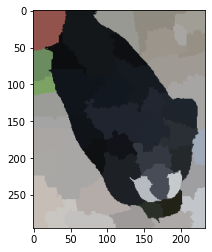

In [5]:
#set mask to to average superpixel value
explainer.mask_image(ImageObjectDemo)
plt.imshow(ImageObjectDemo.masked_image)

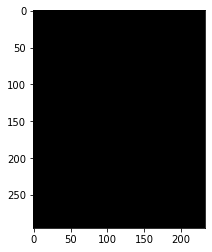

In [6]:
#set mask value to 0
explainer.mask_image(ImageObjectDemo, mask_value = 0)
plt.imshow(ImageObjectDemo.masked_image)

# Demo: Sample Superpixels

In [7]:
#create 3 samples
superpixel_samples, sampled_images = explainer.sample_superpixels(ImageObjectDemo, 3)

<class 'list'>
<class 'numpy.ndarray'>
(295, 233, 3)


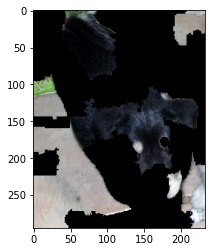

In [8]:
print(type(sampled_images))
#showing first sample
print(type(sampled_images[0]))
print(np.shape(sampled_images[0]))
plt.imshow(sampled_images[0])

# Demo: BlackBox IO

In [9]:
# blackbox output on sampled images
blackbox_out = explainer.map_blaxbox_io(sampled_images)
print(blackbox_out)
#blackbox output on original image
blackbox_out = explainer.map_blaxbox_io((ImageObjectDemo.original_image,))
print(blackbox_out)



[[0.94515514 0.05484483]
 [0.9398338  0.0601662 ]
 [0.9108964  0.08910365]]
[[0.0848178  0.91518223]]


# Demo: Explain Image

Class stats: Dog
Intercept:0.5511175827661856 R^2:0.4867613739699047 Prediction on ori. image [-24.31849807]
Class stats: Cat
Intercept:0.4488824202109022 R^2:0.4867613702391137 Prediction on ori. image [25.31849753]


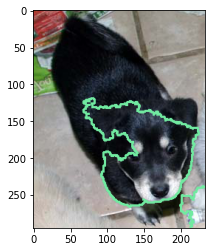

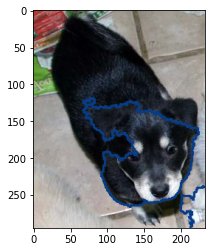

In [10]:
explainer.explain_image(ImageObjectDemo, 1000, classes, top_labels = 2, num_superpixels = 10)
#In the images we fit a LLR on,
# Image 1: the same score for dog as the blackbox classifier gave. 
# Image 2: the same score for cat as the blackbox classifier gave.

# Since it is a dog picture, then in 
# Image 1: the target values are high values. 
# Image 2: target values are low values 

# Good sign that the superpixels coicinde, this means that:
# - Superpixels that are dog-like give a low score for cats. 